In [28]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# TODO: Add this as an script 
# TODO: Add heatmap for diff of median and std

In [29]:
from mic_analysis.variables import all_variables_names_enhanced
from confapp import conf
import pandas as pd
from mic_analysis.datasets import data_filter
from natsort import natsorted
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.size"] = "14"

In [30]:
pairs_to_plot = {
    "indiv": ("HET_HET-HET", "DEL_DEL-DEL"),
    "group": ("HET_HET", "DEL_DEL"), 
    "indiv_nb": ("HET-DEL", "DEL-HET")
}
default_replicate_treatment = '_standardized'

# TODO: Make this mapping of variables general for all scripts
mapping_variables_names = {
    "mean_distance_to_center_of_group_standardized": "group dispersion",
    "nb_angle": "followership",
    "nb_distance_standardized": "interindividual distance",
    "normal_acceleration_standardized": "turning accel",
    "normed_distance_to_origin_standardized": "distance to center",
    "polarization_order_parameter_standardized": "polarization", 
    "rotation_order_parameter_standardized": "rotation", 
    "speed_standardized": "speed"
} 

In [31]:
videos_table = pd.read_csv(conf.VIDEOS_INDEX_FILE_NAME)

In [32]:
partition_col = "line_experiment"
videos_to_plot = data_filter(videos_table, filters=conf.DATA_FILTERS['experiment_1'])

In [40]:
individual_vars = [
    ("speed_standardized", "mean"),
    ("speed_standardized", "median"),
    ("speed_standardized", "std"),
    ("normed_distance_to_origin_standardized", "mean"),
    ("normed_distance_to_origin_standardized", "median"),
    ("normed_distance_to_origin_standardized", "std"),
    ("normal_acceleration_standardized", "mean"),
    ("normal_acceleration_standardized", "mean"),
    ("normal_acceleration_standardized", "std"),
]
group_vars = [
    ("mean_distance_to_center_of_group_standardized", "mean"),
    ("mean_distance_to_center_of_group_standardized", "median"),
    ("mean_distance_to_center_of_group_standardized", "std"),
    ("polarization_order_parameter_standardized", "mean"),
    ("polarization_order_parameter_standardized", "median"),
    ("polarization_order_parameter_standardized", "std"),
    ("rotation_order_parameter_standardized", "mean"),
    ("rotation_order_parameter_standardized", "median"),
    ("rotation_order_parameter_standardized", "std"),
]
indiv_nb_vars = [
    ("nb_distance_standardized", "mean"),
    ("nb_distance_standardized", "median"),
    ("nb_distance_standardized", "std"),
    ("nb_angle", "ratio_in_front"),
]

variables = individual_vars + group_vars + indiv_nb_vars
variables = [str(var_) for var_ in variables]

partitions = natsorted(videos_to_plot[partition_col].unique())
heatmap_vals = {}
heatmap_pvals = {}
for partition in partitions:
    stats_file = os.path.join(
        conf.GENERATED_FIGURES_PATH,
        f"summary_{partition_col}",
        partition,
        "all_test_stats.csv",
    )
    if os.path.isfile(stats_file):
        stats = pd.read_csv(stats_file)

        # variables = [
        #     var
        #     for var in stats.variable.unique()
        #     if default_replicate_treatment in var and "nb_angle" not in var
        # ]
        # variables += ["('nb_angle', 'ratio_in_front')"]
        # variables = natsorted(variables)

        vals = {}
        p_vals = {}
        for variable in variables:
            if variable in stats['variable'].unique():
                var_stats = stats[stats["variable"] == variable]
                var_type = var_stats["var_type"].unique()[0]
                has_WT = var_stats.group_a.str.contains("WT").sum() > 0
                pair_to_plot = pairs_to_plot[f"{var_type}"]
                variable_name = eval(variable)
                variable_name = (
                    f"{mapping_variables_names[variable_name[0]]} ({variable_name[1]})"
                )
                if "nb_distance" in variable:
                    pair_to_plot = ("HET-HET", "DEL-DEL")
                group_a = pair_to_plot[0]
                group_b = pair_to_plot[1]
                var_stats_ = var_stats[
                    (var_stats.group_a == group_a) & (var_stats.group_b == group_b)
                ]
                if len(var_stats_) == 1:
                    var_stats_ = var_stats_.iloc[0]
                    if not np.isnan(var_stats_["value"]):
                        vals[variable_name] = var_stats_["stat_b"] - var_stats_["stat_a"]
                        p_vals[variable_name] = var_stats_["p_value"]
                    else:
                        vals[variable_name] = np.nan
                        p_vals[variable_name] = 1
                else:
                    vals[variable_name] = np.nan
                    p_vals[variable_name] = 1
            else:
                print(f"{variable} not in stats")

        if vals:
            heatmap_vals[partition] = vals
            heatmap_pvals[partition] = p_vals

heatmap_vals = pd.DataFrame(heatmap_vals)
heatmap_pvals = pd.DataFrame(heatmap_pvals)

heatmap_stars = heatmap_pvals.copy()
heatmap_stars[heatmap_pvals >= 0.05] = ""
heatmap_stars[heatmap_pvals < 0.05] = "*"

heatmap_pvals[heatmap_vals.isna()] = np.nan
heatmap_stars[heatmap_vals.isna()] = np.nan

heatmap_vals.dropna(axis=1, inplace=True)
heatmap_pvals.dropna(axis=1, inplace=True)
heatmap_stars.dropna(axis=1, inplace=True)

In [41]:
heatmap_vals

,ap1g1_1_1,apbb1_1_1,asap1b_7_1,cdon_1_1,evi5b_6_1,gli2b_1_1,gli3_7_1,itsn1_1_1,itsn1_3_1,kif1b_1_1,...,mef2ca_2_1,reln_2_1,shank3a_2_1,shank3b_1_1,src_1_1,srrm3_17_1,srrm4_12_1,vav2_1_1,vdac3_5_1,vti1a_1_1
speed (mean),0.296467,-0.257759,-0.032005,-0.405271,0.245433,-0.005812,0.106009,-0.175895,0.202995,-0.209732,...,-0.169674,-0.218116,-0.044412,0.043458,0.185763,0.302769,0.076552,-0.037270,0.079213,0.222862
speed (median),0.303250,-0.257630,0.004654,-0.389479,0.266496,0.021419,0.072466,-0.241807,0.242499,-0.133054,...,-0.137799,-0.074071,-0.086352,-0.080797,0.206302,0.302983,0.066269,-0.037000,0.044044,0.222302
speed (std),0.032659,-0.046981,-0.143941,-0.145198,0.173849,-0.087811,0.084041,-0.025844,0.060193,0.058161,...,-0.091476,-0.147330,0.077013,0.083268,0.046337,-0.007680,0.006388,-0.127004,0.080484,0.089878
distance to center (mean),-0.192038,0.046538,-0.267560,0.415400,-0.207092,0.087301,-0.239653,-0.103799,0.154633,-0.042190,...,0.162519,0.081348,-0.064687,0.111949,-0.419322,-0.058835,-0.221212,-0.398581,-0.109772,-0.055106
distance to center (median),-0.342160,0.017617,-0.126375,0.503728,-0.185512,0.005210,-0.097398,-0.059027,0.330668,-0.106847,...,0.162723,0.147671,-0.098474,0.055792,-0.387043,-0.070237,-0.266125,-0.383372,-0.130849,-0.099703
distance to center (std),-0.034950,-0.085471,0.162525,0.004871,0.116460,-0.066789,0.207070,0.103349,-0.032304,-0.079659,...,-0.150262,-0.087315,0.035354,-0.025716,0.205158,0.186871,0.069710,0.142757,0.065781,0.033364
turning accel (mean),-0.033936,-0.028436,-0.005281,0.024529,-0.023103,0.005828,0.004411,0.008107,-0.002647,-0.028226,...,-0.012405,-0.002568,0.030073,0.012954,-0.013426,-0.042283,-0.016721,-0.001832,-0.021911,0.013232
turning accel (std),0.141185,-0.011536,-0.022120,0.022556,0.091537,-0.062094,0.011599,-0.141253,0.117413,-0.195985,...,-0.037919,-0.120033,-0.004809,0.259538,0.069063,-0.015318,-0.017775,-0.134095,0.104909,0.071392
group dispersion (mean),-0.057283,-0.094178,-0.216255,-0.070884,0.126392,-0.313709,0.269429,-0.128153,0.161206,0.108107,...,0.029713,-0.165688,-0.141229,0.066836,0.050974,8.633691,0.000390,-0.173802,-0.097816,0.342165
group dispersion (median),0.015400,0.024469,-0.068121,-0.083012,0.024876,-0.060795,0.361225,-0.018819,0.273044,0.016633,...,-0.060773,-0.030833,0.021426,-0.010050,0.040072,8.445154,0.013296,-0.018031,0.018120,0.089325


<AxesSubplot:>

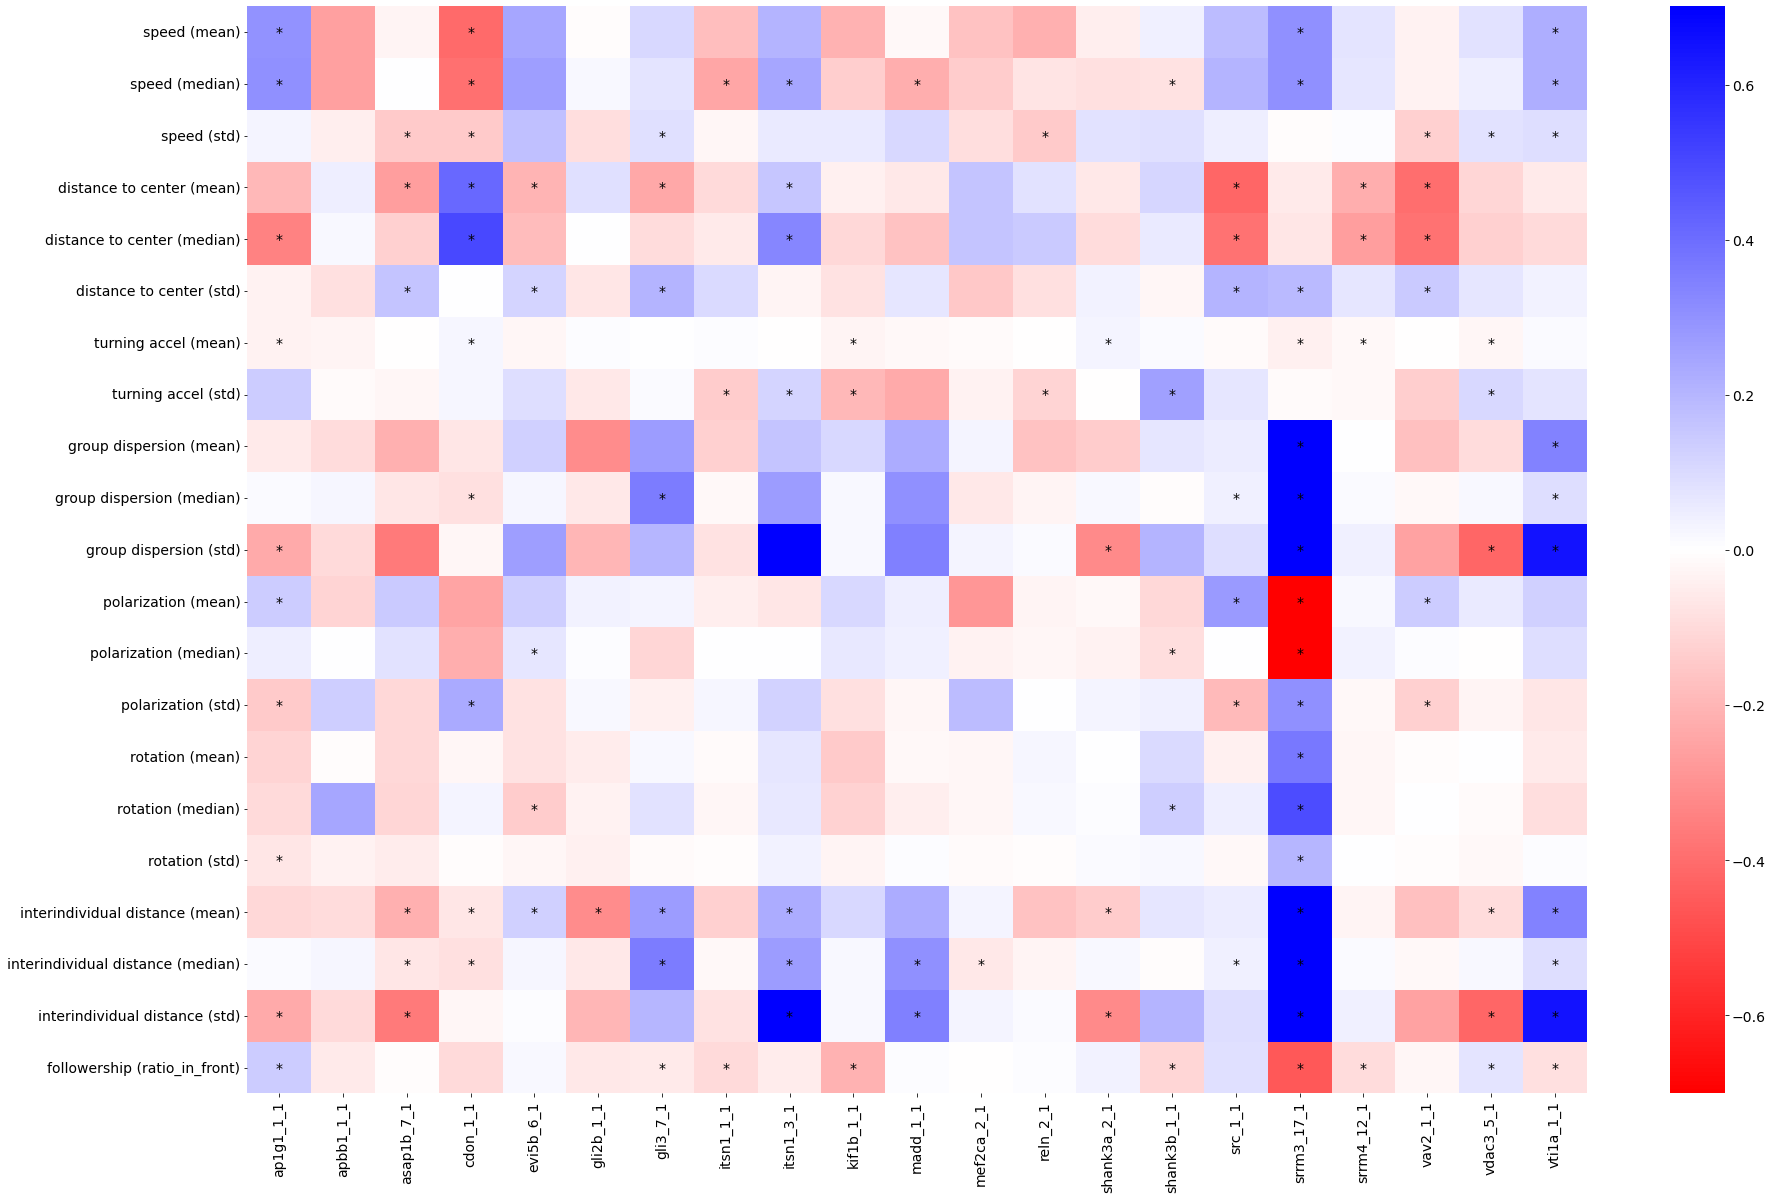

In [42]:
fig, ax = plt.subplots(1,1, figsize=(30, 20))
lim = np.max(np.abs(heatmap_vals[[c for c in heatmap_vals.columns if 'srrm3_17' not in c]].values))
sns.heatmap(
    data=heatmap_vals, 
    cmap='bwr_r', 
    annot=heatmap_stars, 
    fmt="", 
    annot_kws={"c":'k', "fontsize":14},
    vmin=-lim,
    vmax=lim,
)

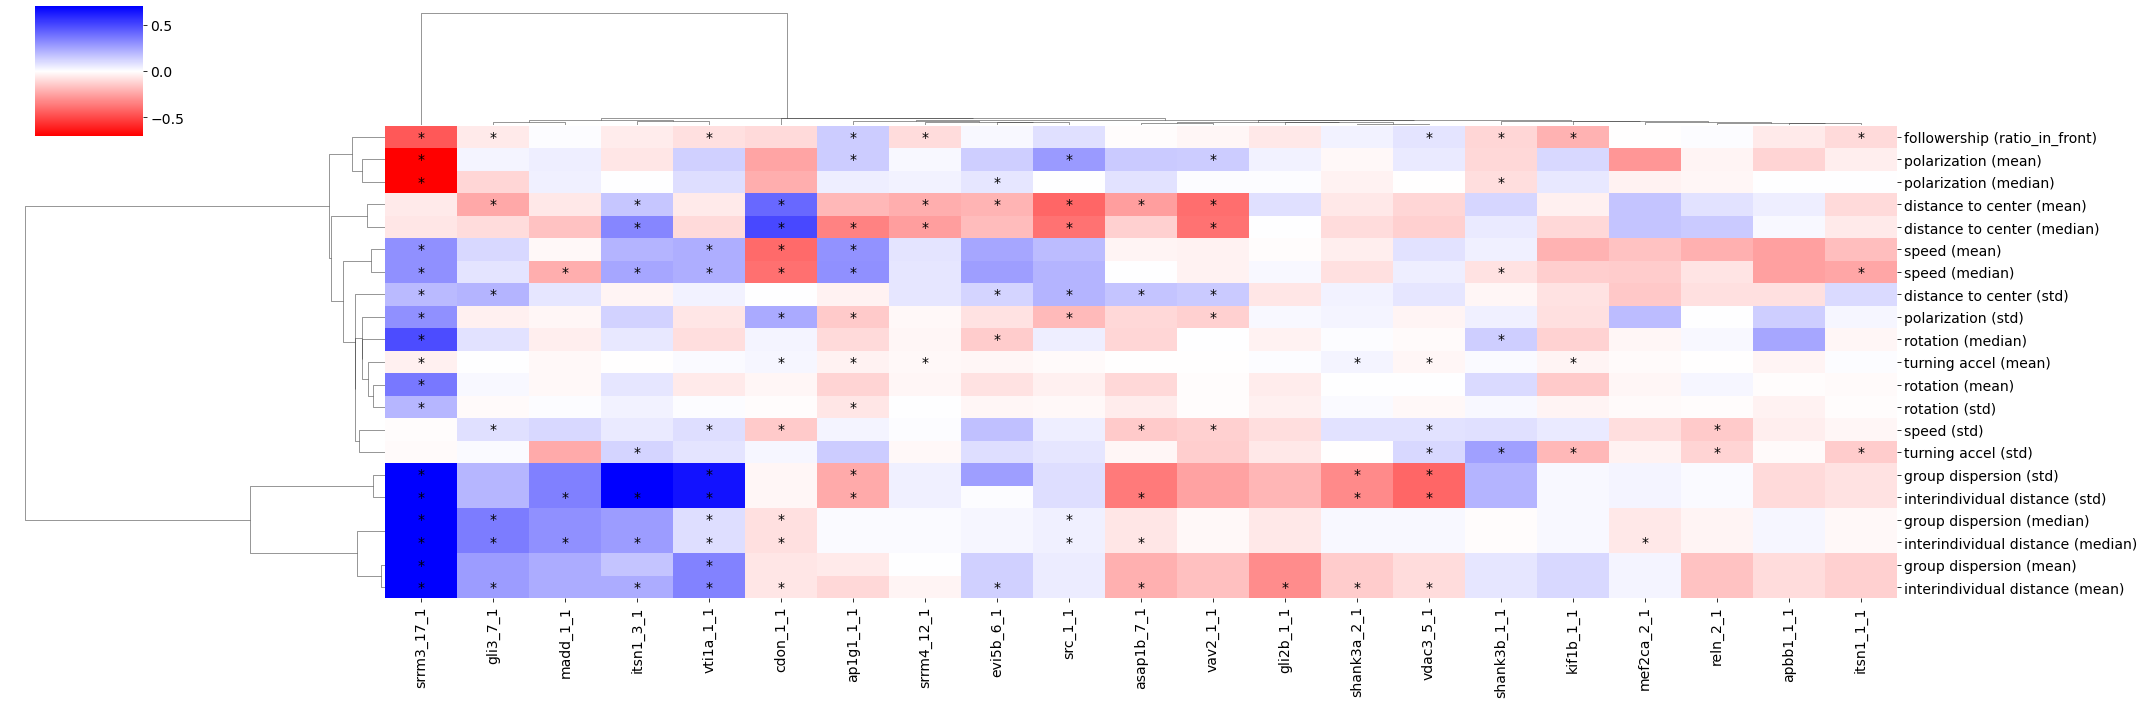

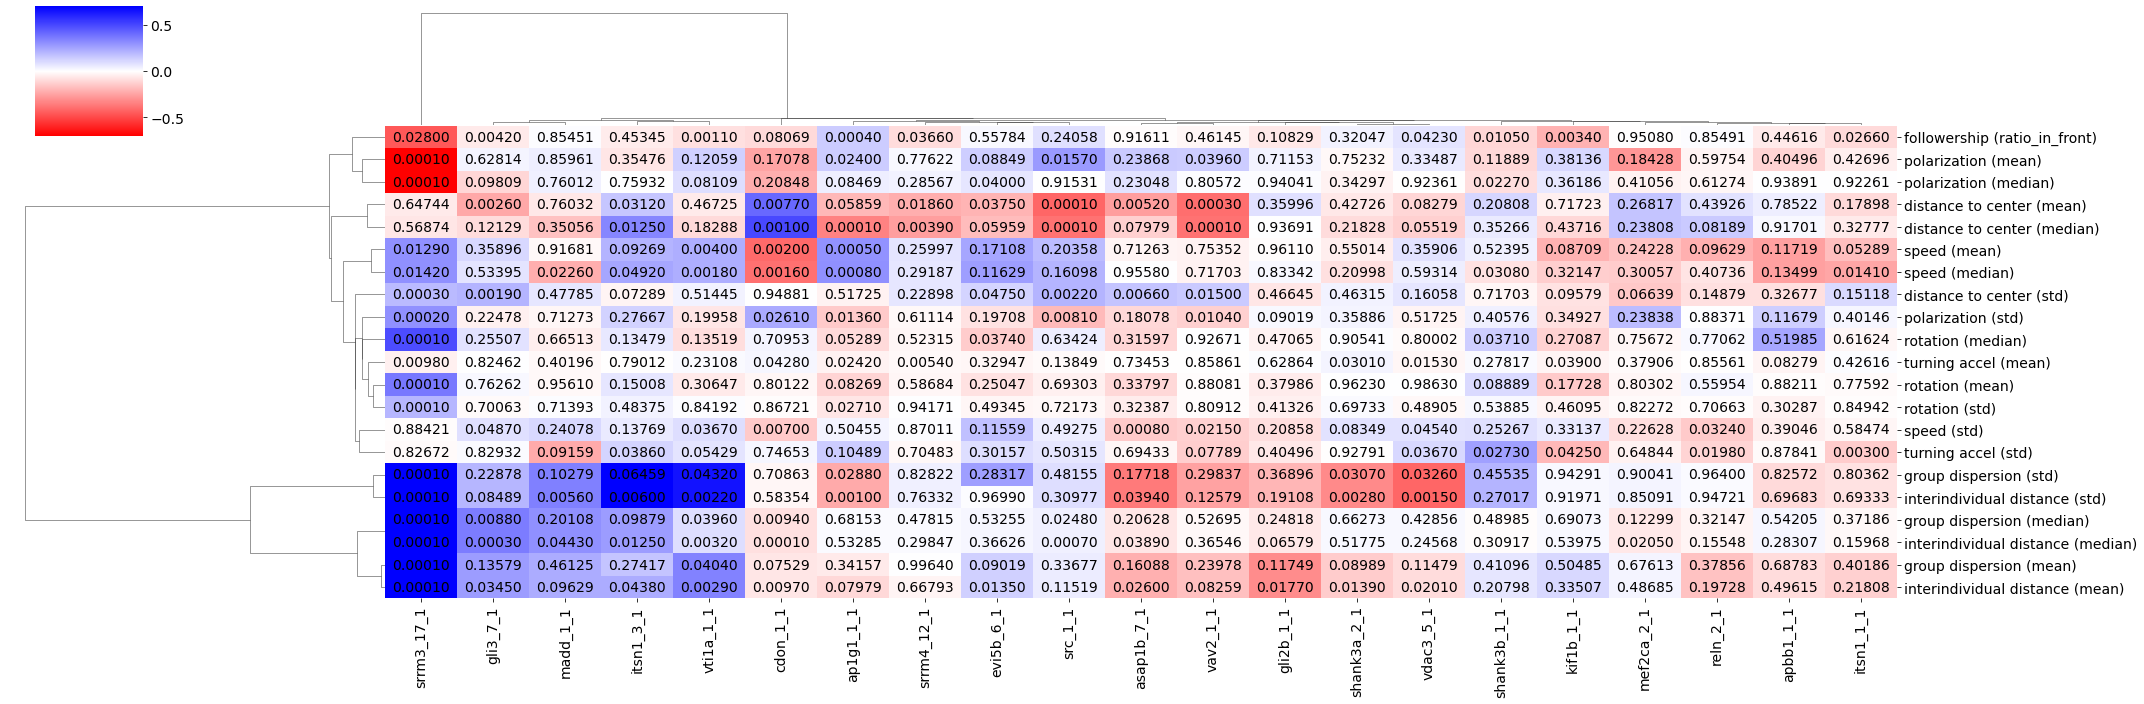

In [44]:
formats = {
    "stars": {"suffix": "", "annot": heatmap_stars, "fmt": ""}, 
    "_pvals": {"suffix": "_pvals", "annot": heatmap_pvals, "fmt": ".5f"},
}
for name, info in formats.items():
    sns.clustermap(
        data=heatmap_vals, 
        cmap='bwr_r', 
        figsize=(30, 10), 
        annot=info["annot"], 
        fmt=info["fmt"], 
        annot_kws={"c":'k', "fontsize":14},
        col_cluster=True, 
        row_cluster=True,
        vmin=-lim, 
        vmax=lim,
    )
    fig = plt.gcf()
    fig.savefig(os.path.join(conf.GENERATED_FIGURES_PATH, f"summary_{partition_col}", f"heatmap{info['suffix']}.pdf"))
    fig.savefig(os.path.join(conf.GENERATED_FIGURES_PATH, f"summary_{partition_col}", f"heatmap{info['suffix']}.png"))